In [1]:
import os
import glob
import shutil
import numpy as np
import random
from tqdm import tqdm
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import load_model, model_from_json, Model
from tensorflow.keras.layers import *
from tensorflow.keras import losses
from tensorflow.keras.preprocessing import image as kpi
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16

In [2]:
def get_image_data(img_path, image_size, space='rgb'):
    if space=='rgb':
        img = kpi.load_img(img_path, target_size=image_size)
        x = kpi.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        data = x[0]
    elif space=='gray':
        img = kpi.load_img(img_path, target_size=image_size, grayscale=True)
        x = kpi.img_to_array(img)
        x /= 255.
        data = x
    return data

In [3]:
def VGG_FCN():
    i_x = Input(shape=(480, 640, 3))
    x = VGG16(include_top=False, weights='imagenet')(i_x)
    x = Lambda(lambda x: x/255.)(x)
    o_x = Conv2D(1, kernel_size=(3,3), strides=(1,1),padding="SAME")(x)
    model = Model(inputs=i_x, outputs=o_x)
    return model

In [4]:
model = VGG_FCN()
model.summary()
model.compile(loss='mse', optimizer="sgd", metrics=[])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 480, 640, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
lambda (Lambda)              (None, 15, 20, 512)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 15, 20, 1)         4609      
Total params: 14,719,297
Trainable params: 14,719,297
Non-trainable params: 0
_________________________________________________________________


In [5]:
X = np.zeros((698, 480, 640, 3), np.float32)
Y = np.zeros((698, 15, 20, 1), np.float32)

for img_id in tqdm(range(698)):
    x = get_image_data('./EMOd/images/%04d.jpg'%(img_id+1), (480, 640), 'rgb')
    y = get_image_data('./EMOd/sensitivity/%04d_sensitivity.jpg'%(img_id+1), (15, 20), 'gray')
    X[img_id] = x
    Y[img_id] = y

  0%|          | 0/698 [00:00<?, ?it/s]/home/mathsci/miniconda3/envs/n-cript/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
100%|██████████| 698/698 [00:11<00:00, 63.37it/s]


In [6]:
model.fit(X, Y, batch_size=4, shuffle=True, epochs=30, verbose=1, validation_split=0.2)

Epoch 1/30
140/140 [==============================] - 473s 3s/step - loss: 0.1155 - val_loss: 0.0580
Epoch 2/30
140/140 [==============================] - 398s 3s/step - loss: 0.0788 - val_loss: 0.0746
Epoch 3/30
140/140 [==============================] - 401s 3s/step - loss: 0.0739 - val_loss: 0.0576
Epoch 4/30
140/140 [==============================] - 415s 3s/step - loss: 0.0686 - val_loss: 0.0637
Epoch 5/30
140/140 [==============================] - 428s 3s/step - loss: 0.0675 - val_loss: 0.0531
Epoch 6/30
140/140 [==============================] - 408s 3s/step - loss: 0.0626 - val_loss: 0.0599
Epoch 7/30
140/140 [==============================] - 423s 3s/step - loss: 0.0618 - val_loss: 0.0555
Epoch 8/30
140/140 [==============================] - 402s 3s/step - loss: 0.0640 - val_loss: 0.0540
Epoch 9/30
140/140 [==============================] - 411s 3s/step - loss: 0.0595 - val_loss: 0.0828
Epoch 10/30
140/140 [==============================] - 385s 3s/step - loss: 0.0540 - val_lo

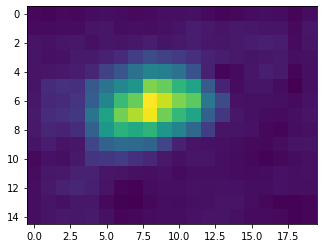

In [7]:
x = np.expand_dims(get_image_data('./EMOd/images/0003.jpg', (480, 640), 'rgb'), axis=0)
y = model.predict(x)
plt.imshow(y[0,:,:,0])

In [8]:
model.save('sensitivity_map_model') 

/home/mathsci/miniconda3/envs/n-cript/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/home/mathsci/miniconda3/envs/n-cript/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1397: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: sensitivity_map_model/assets


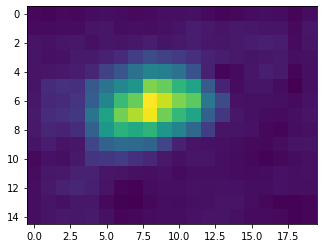

In [9]:
new_model = load_model('sensitivity_map_model')
new_y = model.predict(x)
plt.imshow(new_y[0,:,:,0])